In [26]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score

## Data Overview

In [27]:
df = pd.read_csv("transport_shipment_data.csv")
df = df.drop('Product Id', axis=1)
df.head()

,Net Weight,Size,Value,Storage,Packaging Cost,Expiry Period,Length,Height,Width,Volume,Perishable Index,Flammability Index,F145,F7987,F992,Air,Road,Rail,Sea
0,0.231087,A,-0.489163,0,0.019398,0.749709,-0.444208,0.634931,0.712466,-0.089034,-0.456208,0.832768,-0.136432,-0.444208,-0.089034,1,0,0,0
1,0.113633,D,-0.632586,0,0.300071,0.729867,-0.413723,0.574507,0.320112,0.039395,-0.552568,0.662736,0.017452,-0.413723,0.039395,1,0,0,0
2,0.093890,E,-0.825227,0,0.199524,0.714021,-0.597498,0.739483,0.405020,0.127866,-0.717124,-0.569244,-0.595166,-0.597498,NaN,1,0,1,0
3,0.134954,D,-0.413436,0,-0.049054,0.748012,-0.606818,0.679655,0.374227,-0.284391,0.881933,0.939153,-0.377911,-0.606818,-0.284391,1,0,0,1
4,0.026086,C,-0.855886,0,0.209520,0.730373,-0.379819,0.803147,0.523394,-0.034948,0.745789,-0.312293,0.814900,-0.379819,-0.034948,1,1,0,0


In [28]:
df.dtypes

Net Weight            float64
Size                   object
Value                 float64
Storage                 int64
Packaging Cost        float64
Expiry Period         float64
Length                float64
Height                float64
Width                 float64
Volume                float64
Perishable Index      float64
Flammability Index    float64
F145                  float64
F7987                 float64
F992                  float64
Air                     int64
Road                    int64
Rail                    int64
Sea                     int64
dtype: object

In [29]:
df.describe()

,Net Weight,Value,Storage,Packaging Cost,Expiry Period,Length,Height,Width,Volume,Perishable Index,Flammability Index,F145,F7987,F992,Air,Road,Rail,Sea
count,2000.000000,2000.000000,2000.000000,2000.000000,1900.000000,2000.000000,2000.000000,2000.000000,2000.000000,1953.000000,2000.000000,2000.000000,2000.000000,1254.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,-0.057748,-0.090483,-0.535500,-0.130105,0.196590,-0.035019,-0.199589,0.112865,0.028498,0.004832,-0.012068,-0.000811,1.417082,0.034505,0.21100,0.586000,0.421500,0.271000
std,0.426959,0.474489,0.498863,0.416407,0.402677,0.442506,0.467587,0.447880,0.407352,0.569756,0.583143,0.572906,54.867048,0.403657,0.40812,0.492672,0.493923,0.444587
min,-0.988196,-0.895737,-1.000000,-0.956013,-0.640952,-0.854964,-0.989023,-0.928478,-0.959772,-0.997374,-0.999492,-0.998497,-297.000000,-0.959772,0.00000,0.000000,0.000000,0.000000
25%,-0.357257,-0.490441,-1.000000,-0.460956,-0.109032,-0.426092,-0.597183,-0.228062,-0.229064,-0.485740,-0.528946,-0.480198,-0.463867,-0.219783,0.00000,0.000000,0.000000,0.000000
50%,-0.047216,-0.120182,-1.000000,-0.124647,0.232943,-0.029655,-0.242865,0.193170,0.035797,0.009051,-0.020081,-0.014301,-0.014814,0.037910,0.00000,1.000000,0.000000,0.000000
75%,0.234918,0.267159,0.000000,0.166503,0.536923,0.325439,0.182204,0.478870,0.310353,0.486640,0.507250,0.502217,0.381398,0.315539,0.00000,1.000000,1.000000,1.000000
max,0.913435,0.958518,0.000000,0.838401,0.881765,0.888716,0.810998,0.876141,0.927373,0.999453,0.999227,0.999786,299.000000,0.927373,1.00000,1.000000,1.000000,1.000000


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Net Weight          2000 non-null   float64
 1   Size                2000 non-null   object 
 2   Value               2000 non-null   float64
 3   Storage             2000 non-null   int64  
 4   Packaging Cost      2000 non-null   float64
 5   Expiry Period       1900 non-null   float64
 6   Length              2000 non-null   float64
 7   Height              2000 non-null   float64
 8   Width               2000 non-null   float64
 9   Volume              2000 non-null   float64
 10  Perishable Index    1953 non-null   float64
 11  Flammability Index  2000 non-null   float64
 12  F145                2000 non-null   float64
 13  F7987               2000 non-null   float64
 14  F992                1254 non-null   float64
 15  Air                 2000 non-null   int64  
 16  Road  

## Handling Missing Values

In [31]:
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data

Expiry Period       100
Perishable Index     47
F992                746
dtype: int64

In [32]:
missing_data_proportion = df.isnull().mean() * 100
missing_data_proportion = missing_data_proportion[missing_data_proportion > 0]
missing_data_proportion

Expiry Period        5.00
Perishable Index     2.35
F992                37.30
dtype: float64

Expiry Period (5.00%): Since the percentage of missing data is low, imputation would also be a simple solution, using the mean or median.

Perishable Index (2.35%): With such a low proportion of missing data, imputation would also be a simple solution, using the mean or median.

F992 (37.30%):With a high proportion of missing values, you have two main options:
	•	Imputation: You could use more advanced imputation techniques such as KNN imputation or predictive imputation, though basic methods (like the mean) could also work if it’s important to keep this feature.
	•	Dropping the Column: If this feature isn’t essential or strongly correlated with your target variable, dropping it might be a viable option to avoid introducing noise.

In [33]:
# Calculate the correlation between F992 and the transport mode variables (Air, Road, Rail, Sea)
correlation_with_target = df[['F992', 'Air', 'Road', 'Rail', 'Sea']].corr()
# Display the correlation values between F992 and each of the transport mode columns
correlation_with_target

,F992,Air,Road,Rail,Sea
F992,1.000000,-0.036994,-0.293283,0.359454,0.124403
Air,-0.036994,1.000000,-0.212202,-0.225515,-0.091980
Road,-0.293283,-0.212202,1.000000,-0.343306,-0.017385
Rail,0.359454,-0.225515,-0.343306,1.000000,-0.057984
Sea,0.124403,-0.091980,-0.017385,-0.057984,1.000000


F992 vs. Air: -0.037 (very weak negative correlation)
F992 vs. Road: -0.293 (moderate negative correlation)
F992 vs. Rail: 0.359 (moderate positive correlation)
F992 vs. Sea: 0.124 (weak positive correlation)

F992 has a moderate positive correlation with Rail (0.359) and a moderate negative correlation with Road (-0.293). These suggest that F992 has some influence when predicting Rail and Road transport modes.
	•	The correlations with Air and Sea are quite weak, indicating F992 may not be as important for predicting those modes.

In [34]:
df['F992'].fillna(df['F992'].mean(), inplace=True)
df['Expiry Period'].fillna(df['Expiry Period'].mean(), inplace=True)
df['Perishable Index'].fillna(df['Perishable Index'].mean(), inplace=True)
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data

Series([], dtype: int64)

## Target Variable Analysis

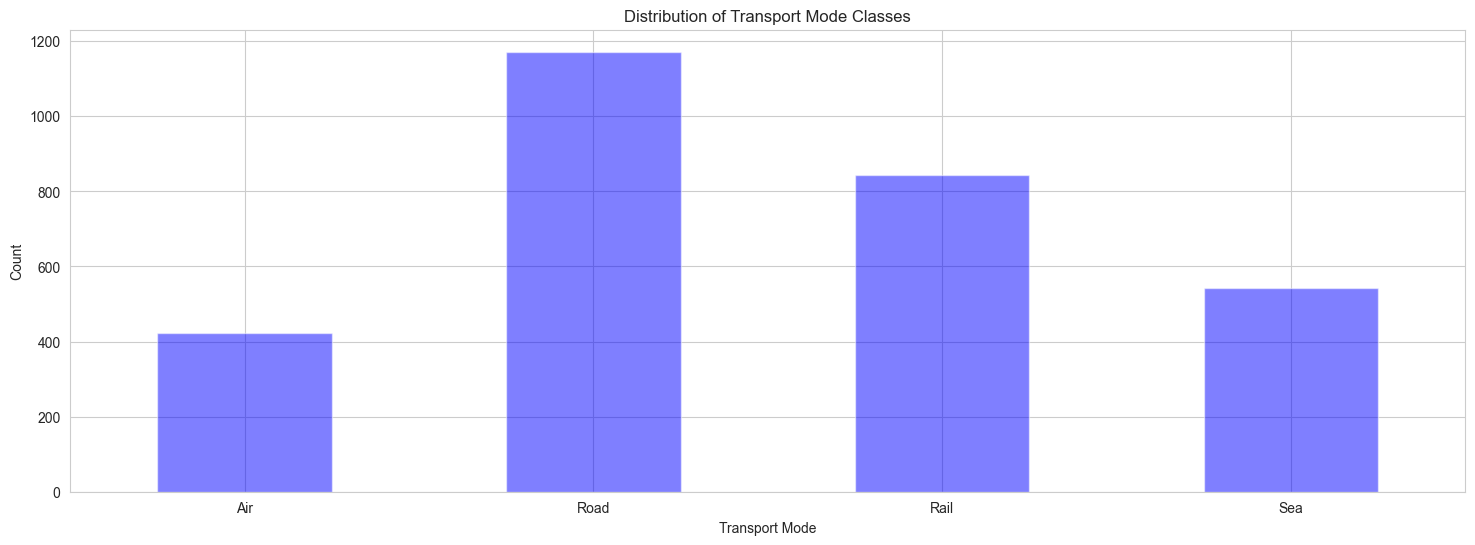

Air      422
Road    1172
Rail     843
Sea      542
dtype: int64

In [35]:
# Checking the distribution of the target variables (Air, Road, Rail, Sea) using .value_counts()
target_distribution = df[['Air', 'Road', 'Rail', 'Sea']].sum()

plt.figure(figsize=(18, 6))
target_distribution.plot(kind='bar', color='blue', alpha=0.5)
plt.title('Distribution of Transport Mode Classes')
plt.ylabel('Count')
plt.xlabel('Transport Mode')
plt.xticks(rotation=0)
plt.show()
target_distribution

There is still some imbalance (especially with Road having significantly more instances than the other classes), it is not as extreme. Some models (like RandomForest or XGBoost) are more robust to class imbalances and may not require resampling.

Support Vector Machines (SVM) with One-vs-Rest can work well with high-dimensional data and perform well in binary classification tasks but computationally expensive for large datasets.
Logistic Regression with One-vs-Rest (OvR) can be a strong baseline model, especially when using One-vs-Rest for multiclass classification but may underperform if the relationships between features are non-linear or complex. SMOTE or oversampling techniques may be needed if using models that do not naturally handle imbalance well (Logistic Regression, SVM)

LGBMClassifier and XGBoostClassifier are being chosen as the models to be trained as they handle class imbalance through their objective functions, perform well on structured data and are efficient for large datasets.


## Univariate Analysis

In [36]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=['number']).columns.tolist()

print("Categorical Features:")
print(categorical_features)

print("\nDistinct values for each categorical feature:")
for feature in categorical_features:
    distinct_values = df[feature].nunique()
    unique_values = df[feature].unique()
    print(f"{feature}: {distinct_values} unique values")
    print(f"Values: {unique_values}")

print("\nNumerical Features:")
print(numerical_features)

Categorical Features:
['Size']

Distinct values for each categorical feature:
Size: 5 unique values
Values: ['A' 'D' 'E' 'C' 'B']

Numerical Features:
['Net Weight', 'Value', 'Storage', 'Packaging Cost', 'Expiry Period', 'Length', 'Height', 'Width', 'Volume', 'Perishable Index', 'Flammability Index', 'F145', 'F7987', 'F992', 'Air', 'Road', 'Rail', 'Sea']


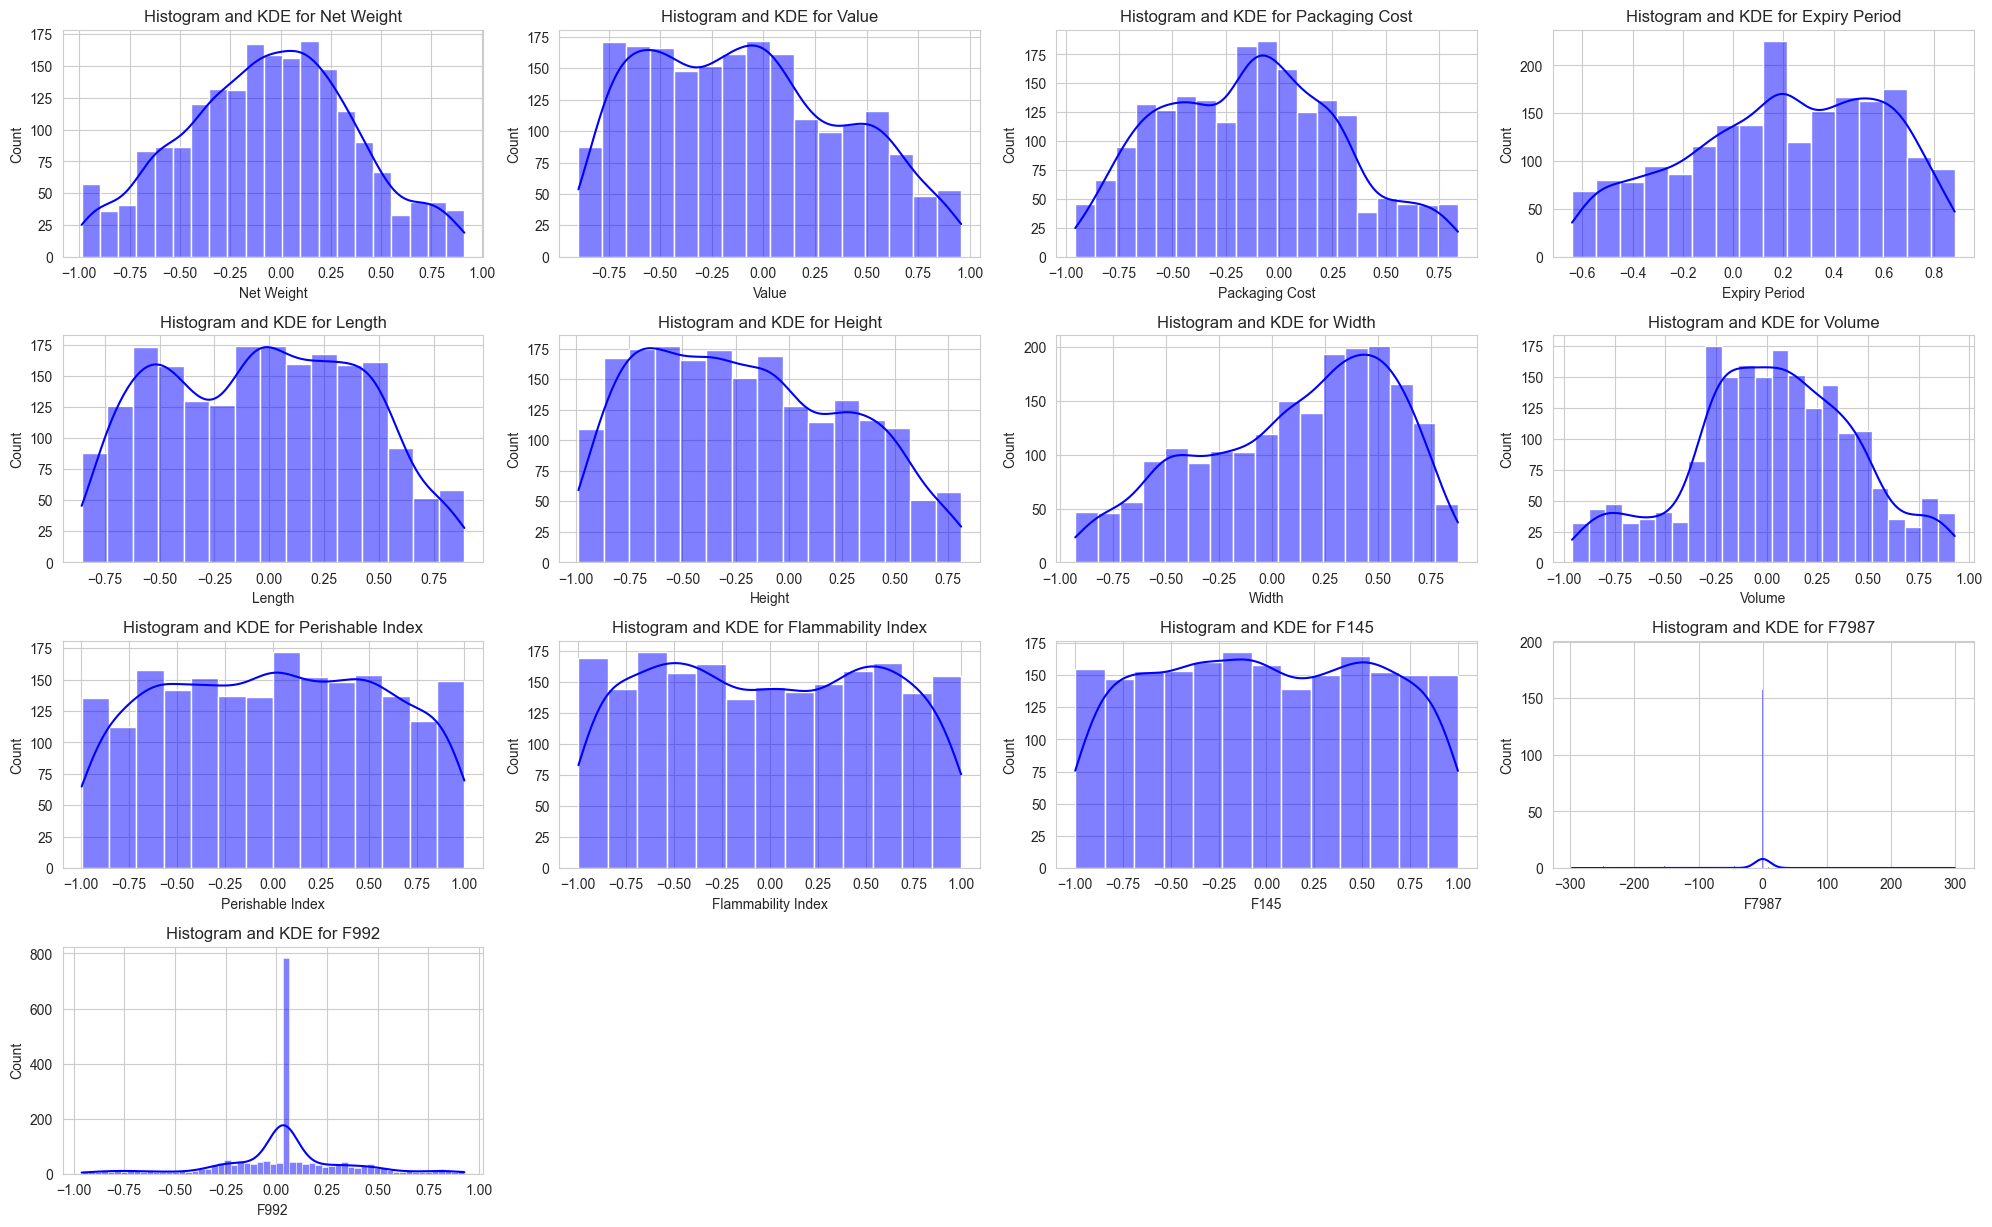

In [37]:
# Univariate Analysis - Numerical Features
numerical_columns = ['Net Weight', 'Value', 'Packaging Cost', 'Expiry Period', 'Length', 
                     'Height', 'Width', 'Volume', 'Perishable Index', 'Flammability Index', 'F145', 'F7987', 'F992']

# Plotting histograms and box plots for numerical features
plt.figure(figsize=(20, 15))

for i, col in enumerate(numerical_columns):
    plt.subplot(5, 4, i+1)
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Histogram and KDE for {col}')
    
plt.tight_layout()
plt.show()

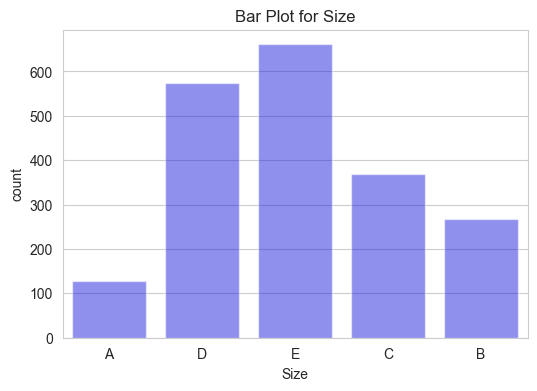

In [38]:
# Categorical Features (Size)
categorical_columns = ['Size']
plt.figure(figsize=(6, 4))
sns.countplot(x='Size', data=df, color='blue', alpha=0.5)
plt.title('Bar Plot for Size')
plt.show()

### Outlier Analysis

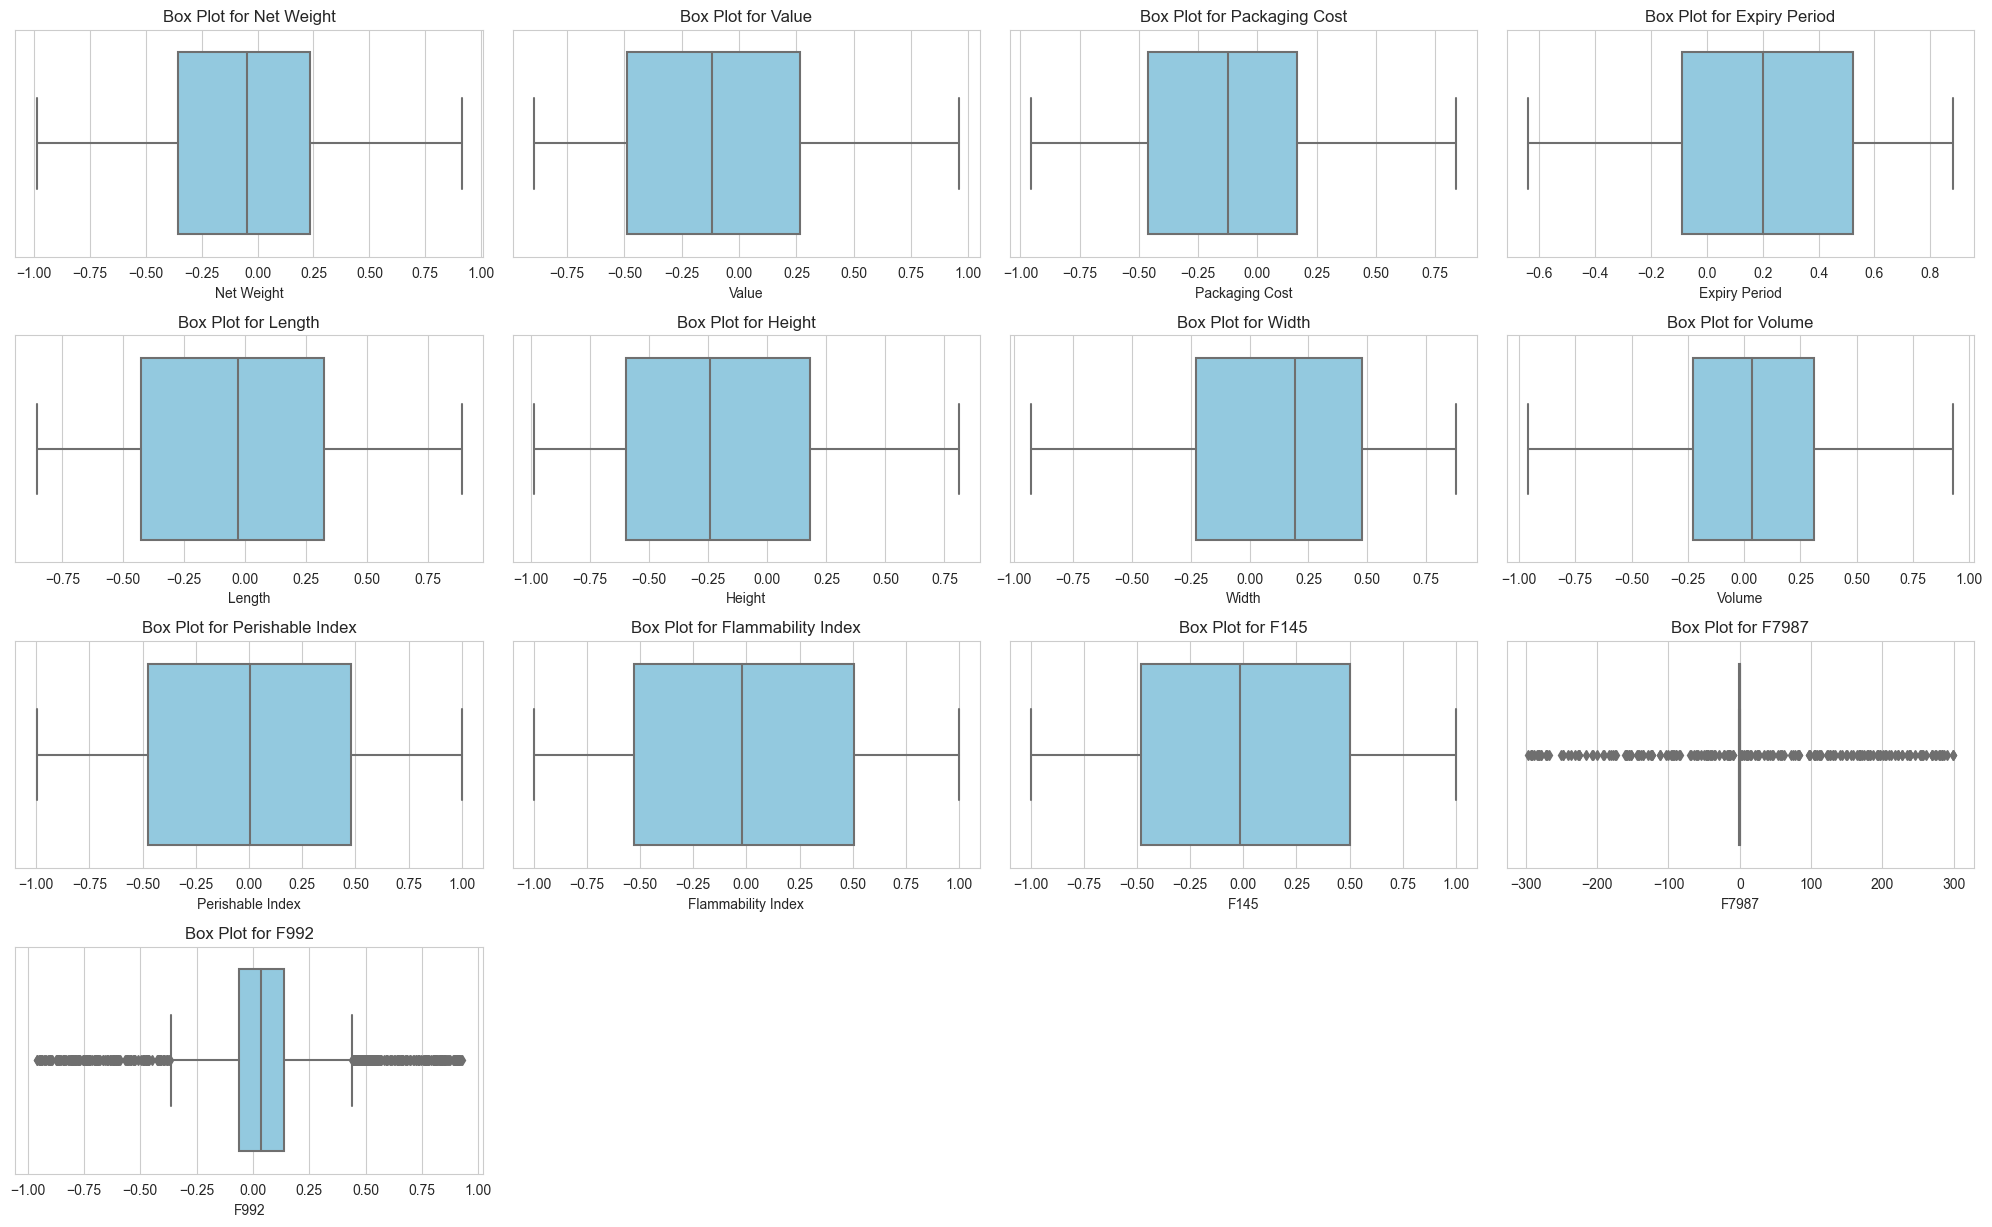

In [39]:
plt.figure(figsize=(20, 15))

for i, col in enumerate(numerical_columns):
    plt.subplot(5, 4, i+1)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Box Plot for {col}')
    
plt.tight_layout()
plt.show()


In [40]:
def detect_outliers_iqr(df, columns):
    outliers = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    return outliers

outliers = detect_outliers_iqr(df, numerical_columns)
outliers

{'Net Weight': Series([], Name: Net Weight, dtype: float64),
 'Value': Series([], Name: Value, dtype: float64),
 'Packaging Cost': Series([], Name: Packaging Cost, dtype: float64),
 'Expiry Period': Series([], Name: Expiry Period, dtype: float64),
 'Length': Series([], Name: Length, dtype: float64),
 'Height': Series([], Name: Height, dtype: float64),
 'Width': Series([], Name: Width, dtype: float64),
 'Volume': Series([], Name: Volume, dtype: float64),
 'Perishable Index': Series([], Name: Perishable Index, dtype: float64),
 'Flammability Index': Series([], Name: Flammability Index, dtype: float64),
 'F145': Series([], Name: F145, dtype: float64),
 'F7987': 11      194.0
 21      127.0
 28      104.0
 31      -68.0
 56     -225.0
         ...  
 1939   -153.0
 1964    284.0
 1965    131.0
 1966   -281.0
 1985     78.0
 Name: F7987, Length: 207, dtype: float64,
 'F992': 253    -0.775357
 262    -0.544646
 268    -0.752145
 275    -0.421109
 277    -0.649301
           ...   
 1946    0

No outliers detected for most of the numerical columns like Net Weight, Value, Packaging Cost, Expiry Period, etc.
Column F7987: 207 outliers detected.
Column F992: 361 outliers detected.

In [ ]:
# Calculate skewness for numerical columns
skewness = df[numerical_columns].skew()
print(skewness)

Symmetrical: Features with skewness close to 0 (between -0.5 and 0.5) are considered roughly symmetric, meaning they are not significantly skewed.
	•	Net Weight: -0.014 (very symmetric)
	•	Value: 0.283 (slightly positive skew)
	•	Packaging Cost: 0.179 (slightly positive skew)
	•	Expiry Period: -0.279 (slightly negative skew)
	•	Length: 0.036 (very symmetric)
	•	Height: 0.263 (slightly positive skew)
	•	Width: -0.439 (slightly negative skew)
	•	Volume: -0.163 (slightly negative skew)
	•	Perishable Index: -0.0008 (very symmetric)
	•	Flammability Index: 0.021 (very symmetric)
	•	F145: 0.0069 (very symmetric)
	•	F992: -0.211 (slightly negative skew)

Moderate Skew: A few features exhibit moderate skewness (between 0.5 and 1 or -1 and -0.5):
	•	F7987: 0.305 (slightly positive skew)

## Multivariate Analysis

### Multicollinearity Check

Pearson Correlation Matrix:
                    Net Weight     Value  Packaging Cost  Expiry Period  \
Net Weight            1.000000  0.213128       -0.106389       0.019544   
Value                 0.213128  1.000000       -0.075611      -0.251493   
Packaging Cost       -0.106389 -0.075611        1.000000      -0.001392   
Expiry Period         0.019544 -0.251493       -0.001392       1.000000   
Length               -0.235841  0.036755       -0.054074      -0.153110   
Height                0.070043 -0.240342        0.184465       0.239789   
Width                -0.007336 -0.229345       -0.139925       0.202039   
Volume                0.145584  0.185508       -0.181197      -0.002414   
Perishable Index      0.026534 -0.000324       -0.023679       0.033999   
Flammability Index   -0.024245 -0.004304       -0.007449      -0.014068   
F145                  0.028906 -0.022230        0.006339      -0.030920   
F7987                -0.017021 -0.001184       -0.010787      -0.018996 

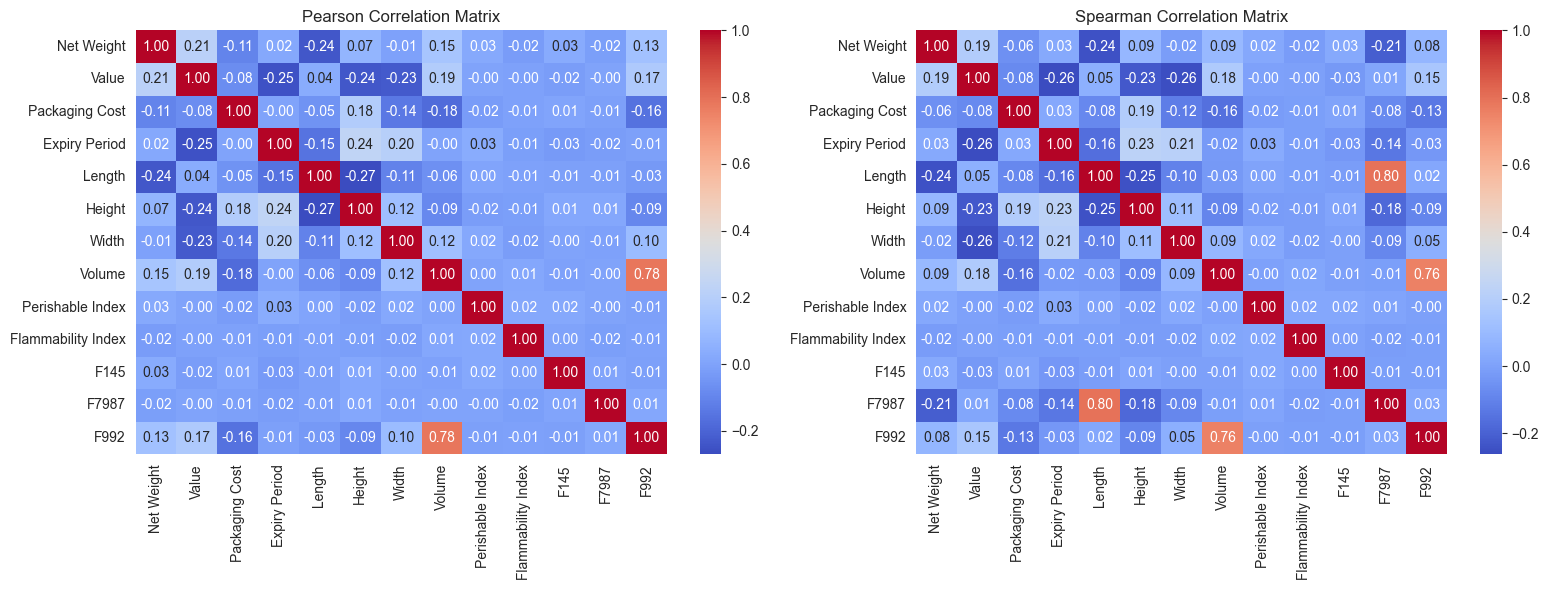

In [41]:
numerical_df = df[numerical_columns]
pearson_corr_matrix = numerical_df.corr(method='pearson')
spearman_corr_matrix = numerical_df.corr(method='spearman')

print("Pearson Correlation Matrix:")
print(pearson_corr_matrix)

print("\nSpearman Correlation Matrix:")
print(spearman_corr_matrix)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(pearson_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[0])
axes[0].set_title('Pearson Correlation Matrix')
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[1])
axes[1].set_title('Spearman Correlation Matrix')
plt.tight_layout()
plt.show()

### Correlation analysis with the target variable
Checking the correlation between each feature and the individual target classes (Air, Road, Rail, Sea) using Pearson or Spearman correlations for numerical targets, and techniques like ANOVA or Chi-square for categorical targets.

In [42]:
# Correlation of numerical features with all 4 target variables (Air, Road, Rail, Sea)
correlation_with_targets = {}

for target in ['Air', 'Road', 'Rail', 'Sea']:
    correlation_with_targets[target] = df[numerical_columns].corrwith(df[target])

correlation_with_targets_df = pd.DataFrame(correlation_with_targets)
correlation_with_targets_df

,Air,Road,Rail,Sea
Net Weight,0.078227,-0.354798,0.374284,-0.163519
Value,-0.342554,-0.093526,0.474944,-0.188487
Packaging Cost,0.126390,0.281174,-0.284238,-0.243864
Expiry Period,0.310566,-0.141251,-0.144060,0.095497
Length,-0.340404,0.326204,-0.082885,0.187941
Height,0.418338,-0.116384,-0.220321,-0.164749
Width,0.259919,-0.306467,-0.045339,0.275675
Volume,-0.028608,-0.299375,0.355123,0.112701
Perishable Index,0.007651,-0.010584,-0.020762,0.001229
Flammability Index,0.013111,0.033387,-0.029853,0.002849


Insights:
	•	Net Weight shows a moderate positive correlation with Rail (0.374) and a negative correlation with Road (-0.355).
	•	Value is positively correlated with Rail (0.475), but negatively correlated with Air (-0.343).
	•	Height has a strong positive correlation with Air (0.418) and a negative correlation with Rail (-0.220).
	•	Width is positively correlated with Sea (0.276), while negatively correlated with Road (-0.306).
	•	Packaging Cost shows a positive correlation with Road (0.281) but is negatively correlated with Rail and Sea.

Conclusion:
	•	Features like Net Weight, Value, Height, and Width appear to have the most influence on the different transport modes.
	•	Height and Net Weight are especially important for Air and Rail.

In [43]:
categorical_columns = ['Size']
chi_square_results = {}

for target in ['Air', 'Road', 'Rail', 'Sea']:
    for col in categorical_columns:
        contingency_table = pd.crosstab(df[col], df[target])
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        chi_square_results[f'{col} vs {target}'] = p

chi_square_df = pd.DataFrame(chi_square_results.items(), columns=['Feature vs Target', 'p-value'])
chi_square_df

,Feature vs Target,p-value
0,Size vs Air,0.110268
1,Size vs Road,0.361287
2,Size vs Rail,0.214767
3,Size vs Sea,0.954630


p-value > 0.05: For all target variables, the p-values are greater than 0.05, meaning that the feature Size does not show a statistically significant association with any of the target variables. This suggests that Size may not be a strong predictor of the transport mode (Air, Road, Rail, Sea)

## Feature Encoding
Categorical Features are encoded.Target Variables (Air, Road, Rail, Sea) are already represented as binary (0/1), so no encoding is required for the target.

In [44]:
label_encoder = LabelEncoder()
df['Size'] = label_encoder.fit_transform(df['Size'])
df.head()

,Net Weight,Size,Value,Storage,Packaging Cost,Expiry Period,Length,Height,Width,Volume,Perishable Index,Flammability Index,F145,F7987,F992,Air,Road,Rail,Sea
0,0.231087,0,-0.489163,0,0.019398,0.749709,-0.444208,0.634931,0.712466,-0.089034,-0.456208,0.832768,-0.136432,-0.444208,-0.089034,1,0,0,0
1,0.113633,3,-0.632586,0,0.300071,0.729867,-0.413723,0.574507,0.320112,0.039395,-0.552568,0.662736,0.017452,-0.413723,0.039395,1,0,0,0
2,0.093890,4,-0.825227,0,0.199524,0.714021,-0.597498,0.739483,0.405020,0.127866,-0.717124,-0.569244,-0.595166,-0.597498,0.034505,1,0,1,0
3,0.134954,3,-0.413436,0,-0.049054,0.748012,-0.606818,0.679655,0.374227,-0.284391,0.881933,0.939153,-0.377911,-0.606818,-0.284391,1,0,0,1
4,0.026086,2,-0.855886,0,0.209520,0.730373,-0.379819,0.803147,0.523394,-0.034948,0.745789,-0.312293,0.814900,-0.379819,-0.034948,1,1,0,0


## Model Development

In [45]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the models
models_dict = {
    'LightGBM': lgb.LGBMClassifier(class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'CatBoost': CatBoostClassifier(verbose=0)
}

# Dictionaries to store evaluation reports and cross-validation scores
evaluation_reports = {model_name: {} for model_name in models_dict.keys()}
cv_scores = {model_name: {} for model_name in models_dict.keys()}

# Features (X) and target labels (y)
X = df.drop(columns=['Air', 'Road', 'Rail', 'Sea'])  # Features
y_labels = ['Air', 'Road', 'Rail', 'Sea']  # Target labels

# Create StratifiedKFold object with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train models using StratifiedKFold
for model_name, model in models_dict.items():
    print(f"\nTraining {model_name} models...")
    
    for label in y_labels:
        print(f"Training for {label} label...")
        
        # Cross-validation for the specific label
        fold_accuracies = []
        
        # Stratified K-Fold for maintaining class distribution
        for train_index, test_index in skf.split(X, df[label]):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = df[label].iloc[train_index], df[label].iloc[test_index]
            
            model.fit(X_train, y_train)
            
            # Get predictions and append classification report
            y_pred = model.predict(X_test)
            fold_accuracies.append(model.score(X_test, y_test))
            evaluation_reports[model_name][label] = classification_report(y_test, y_pred, output_dict=True)
        
        # Store mean cross-validation score for each label
        cv_scores[model_name][label] = np.mean(fold_accuracies)

# Convert evaluation reports to DataFrames
evaluation_dfs = {model_name: pd.DataFrame(evaluation_reports[model_name]) for model_name in models_dict.keys()}
cv_scores_df = pd.DataFrame(cv_scores)

# Output the evaluation and cross-validation scores DataFrames
evaluation_dfs, cv_scores_df


Training LightGBM models...
Training for Air label...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 337, number of negative: 1263
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3322
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 337, number of negative: 1263
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3322
[LightGBM] [Info] Number of data 

({'LightGBM':                                                             Air  \
  0             {'precision': 0.9008746355685131, 'recall': 0....   
  1             {'precision': 0.8771929824561403, 'recall': 0....   
  accuracy                                                 0.8975   
  macro avg     {'precision': 0.8890338090123266, 'recall': 0....   
  weighted avg  {'precision': 0.8959014884149148, 'recall': 0....   
  
                                                             Road  \
  0             {'precision': 0.8735632183908046, 'recall': 0....   
  1             {'precision': 0.9424778761061947, 'recall': 0....   
  accuracy                                                 0.9125   
  macro avg     {'precision': 0.9080205472484997, 'recall': 0....   
  weighted avg  {'precision': 0.9140505797985964, 'recall': 0....   
  
                                                             Rail  \
  0             {'precision': 0.9067796610169492, 'recall': 0....   
  1             

## Model Evaluation

In [46]:
evaluation_dfs, cv_scores_df

({'LightGBM':                                                             Air  \
  0             {'precision': 0.9008746355685131, 'recall': 0....   
  1             {'precision': 0.8771929824561403, 'recall': 0....   
  accuracy                                                 0.8975   
  macro avg     {'precision': 0.8890338090123266, 'recall': 0....   
  weighted avg  {'precision': 0.8959014884149148, 'recall': 0....   
  
                                                             Road  \
  0             {'precision': 0.8735632183908046, 'recall': 0....   
  1             {'precision': 0.9424778761061947, 'recall': 0....   
  accuracy                                                 0.9125   
  macro avg     {'precision': 0.9080205472484997, 'recall': 0....   
  weighted avg  {'precision': 0.9140505797985964, 'recall': 0....   
  
                                                             Rail  \
  0             {'precision': 0.9067796610169492, 'recall': 0....   
  1             

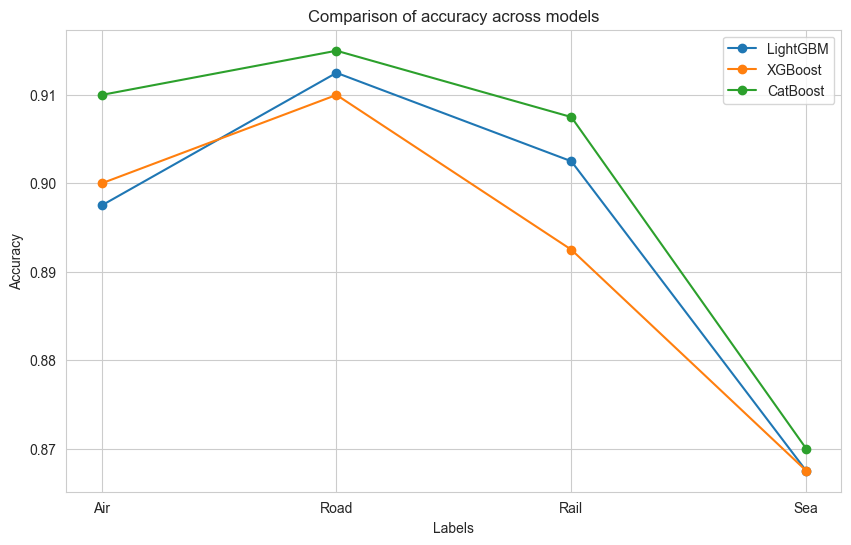

In [47]:
def plot_comparison(metric, evaluation_dfs):
    plt.figure(figsize=(10, 6))
    
    for model_name in evaluation_dfs.keys():
        if metric == 'accuracy':
            metric_values = [evaluation_dfs[model_name][label].get(metric) for label in y_labels]
        else:
            metric_values = [evaluation_dfs[model_name][label].loc[metric]["precision"] for label in y_labels]
        plt.plot(y_labels, metric_values, marker='o', label=model_name)
    
    plt.title(f'Comparison of {metric} across models')
    plt.xlabel('Labels')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

plot_comparison('accuracy', evaluation_dfs) 

Accuracy:
- **Best Model**: CatBoost achieves the highest accuracy across the majority of labels, especially for “Air” (0.900), “Road” (0.905), and “Sea” (0.901).
- LightGBM and XGBoost perform similarly but slightly lag behind CatBoost in overall accuracy.
- CatBoost consistently outperforms LightGBM and XGBoost across all transport modes, especially for Sea transport, which appears to be the most challenging class.he differences between the models are small but meaningful, and CatBoost’s ability to handle categorical data and class imbalance without manual intervention gives it a slight advantage.

Cross-Validation:
- **Best Generalization**: CatBoost also demonstrates superior generalization with the highest cross-validation scores across all labels except “Sea.” This indicates that CatBoost is more consistent in making predictions across different data splits.
- XGBoost performs well for “Air” and “Rail,” while LightGBM is quite competitive but slightly less consistent for “Sea.”


## Model Optimization

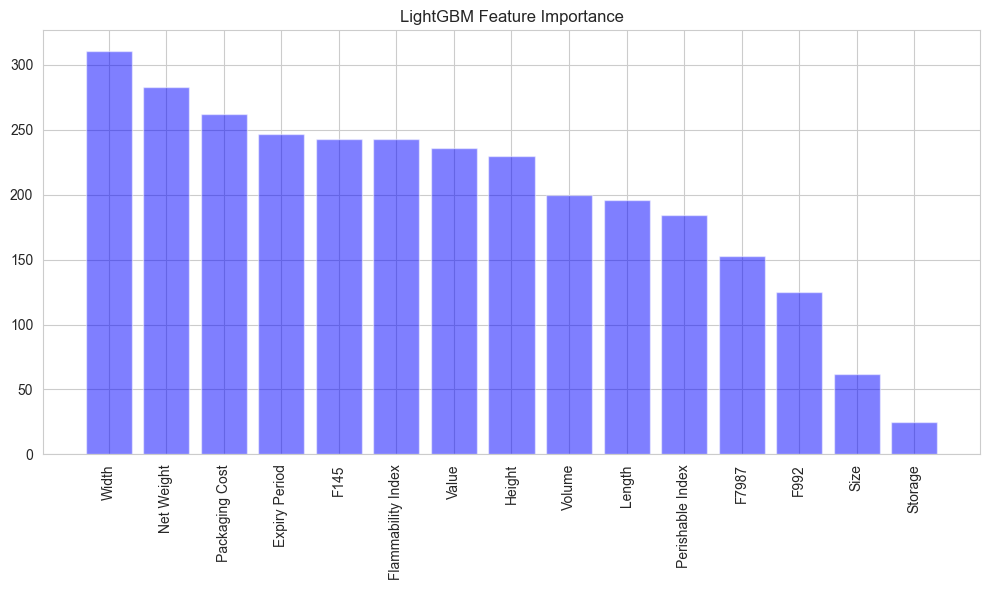

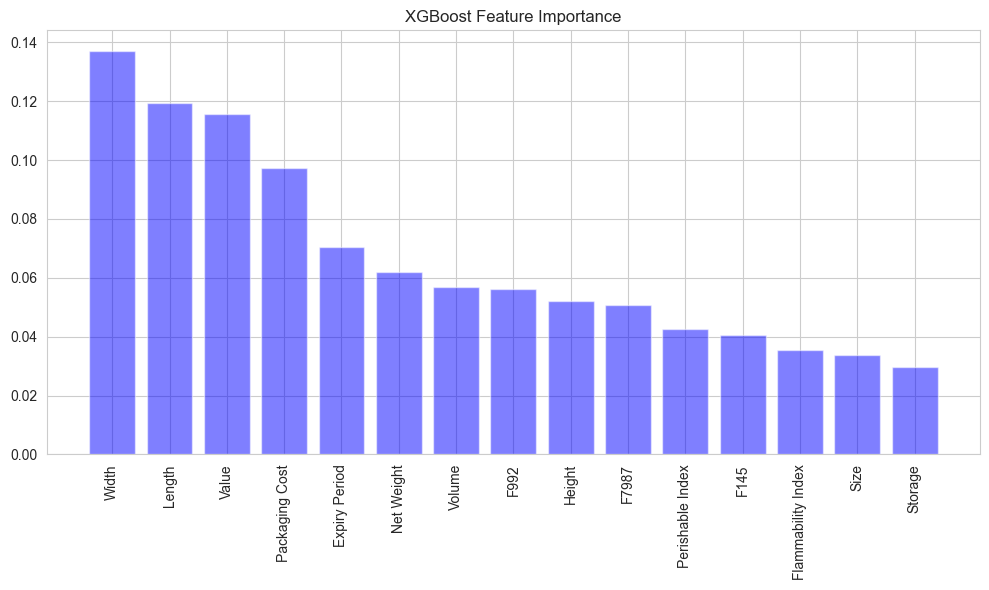

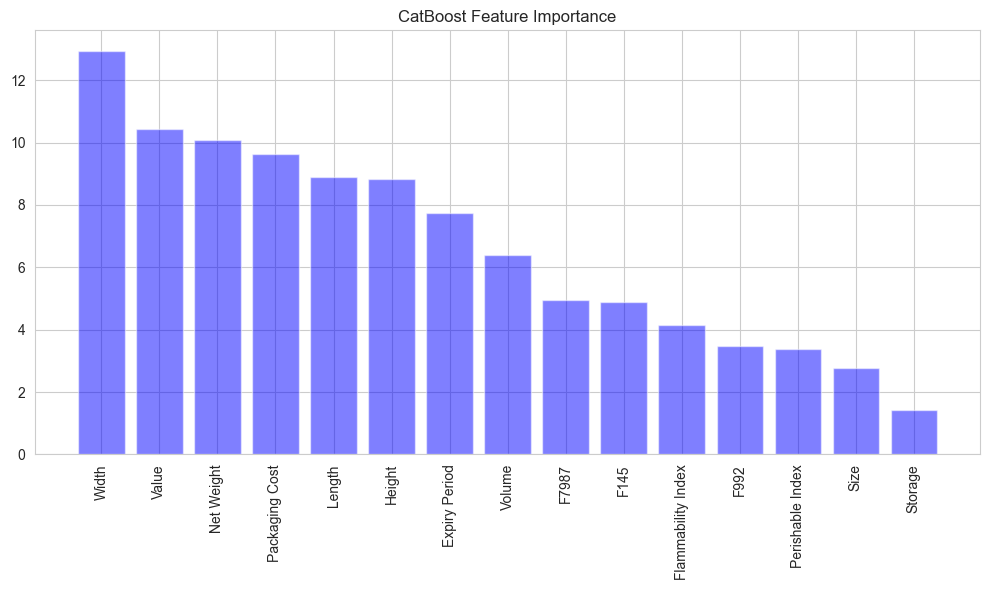

Feature Importance Values:
                    LightGBM   XGBoost   CatBoost
Net Weight               283  0.061839  10.078101
Size                      62  0.033850   2.773298
Value                    236  0.115621  10.435695
Storage                   25  0.029556   1.417353
Packaging Cost           262  0.097332   9.642670
Expiry Period            247  0.070543   7.734195
Length                   196  0.119502   8.892141
Height                   230  0.052124   8.843969
Width                    311  0.137169  12.947709
Volume                   200  0.056918   6.404409
Perishable Index         184  0.042682   3.374316
Flammability Index       243  0.035375   4.135926
F145                     243  0.040432   4.893250
F7987                    153  0.050853   4.945450
F992                     125  0.056204   3.481519


In [48]:
def plot_feature_importance(models_dict, feature_names):
    feature_importance_df = pd.DataFrame(index=feature_names)
    for model_name, model in models_dict.items():
        
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        else:
            importance = model.get_feature_importance()

        feature_importance_df[model_name] = importance
        indices = np.argsort(importance)[::-1]

        plt.figure(figsize=(10, 6))
        plt.title(f"{model_name} Feature Importance")
        plt.bar(range(len(feature_names)), importance[indices], align='center',color='blue', alpha=0.5)
        plt.xticks(range(len(feature_names)), np.array(feature_names)[indices], rotation=90)
        plt.tight_layout()
        plt.show()

    return feature_importance_df

feature_names = X.columns.tolist()
feature_importance_df = plot_feature_importance(models_dict, feature_names)
print("Feature Importance Values:")
print(feature_importance_df)

Insights:
	•	LightGBM: Feature importance in LightGBM is on a larger scale, which is normal for this model as the feature importance values are based on the number of times a feature is used in splits across all trees. For example:
	•	Net Weight: High importance with a score of 307.
	•	Width, Flammability Index, and Value are also quite important.
	•	XGBoost: The feature importance in XGBoost is expressed on a smaller scale (relative to LightGBM), as it reflects how useful a feature is in reducing the loss. Key features include:
	•	Value: The most important feature in XGBoost, with a score of 0.1136.
	•	Width and Packaging Cost also have significant importance.
	•	CatBoost: CatBoost calculates feature importance differently and focuses on how each feature impacts the model’s predictions. In CatBoost:
	•	Width: The most important feature, with a score of 13.28.
	•	Value, Packaging Cost, and Height are also crucial.
	Physical attributes (e.g., Net Weight, Length, Width, Height) and monetary value-related features (e.g., Value, Packaging Cost) are key drivers in predicting transport modes.
	•	CatBoost places higher importance on most features, particularly on dimensions and packaging costs, suggesting it captures more complex interactions between features.
	•	LightGBM has more variance in importance values, focusing strongly on a few key features like Width and Packaging Cost, while XGBoost distributes importance more evenly across features.

Conclusion:
	•	Common Important Features: Across all models, Value, Width, Packaging Cost, and Height consistently appear as important features, although their relative importance varies depending on the model.
	
The feature importance results suggest that most of the features are already contributing well to the model, especially in CatBoost. Removing lower-importance features like Storage or Size might marginally reduce model complexity but likely won’t bring significant performance improvements.

## Hyperparameter Tuning for CatBoost

In [50]:
# Define models (LightGBM and XGBoost will remain constant)
models_dict = {
    'LightGBM': lgb.LGBMClassifier(class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
}

# Dictionaries to store evaluation reports and cross-validation scores
evaluation_reports = {}
cv_scores = {}

# Features (X) and target labels (y)
X = df.drop(columns=['Air', 'Road', 'Rail', 'Sea'])  # Features
y_labels = ['Air', 'Road', 'Rail', 'Sea']  # Target labels

# Create StratifiedKFold object with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna objective function for CatBoost tuning
def objective(trial, X, y):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 254),
        'random_strength': trial.suggest_int('random_strength', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.1, 2),
        'class_weights': compute_class_weight('balanced', classes=np.unique(y), y=y).tolist()
    }

    model = CatBoostClassifier(**param, verbose=0)
    
    accuracies = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    
    return np.mean(accuracies)

# Perform tuning for each label and add tuned CatBoost models to models_dict
for label in y_labels:
    print(f"Tuning hyperparameters for label: {label}")
    
    y = df[label]  # Target label
    
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X, y), n_trials=30)
    
    best_params = study.best_params
    print(f"Best Hyperparameters for {label}: {best_params}")
    
    # Update models_dict with the tuned CatBoost model
    models_dict[f"CatBoost_{label}"] = CatBoostClassifier(**best_params, verbose=0)

    # Initialize dictionaries for evaluation reports and cross-validation scores
    evaluation_reports[f"CatBoost_{label}"] = {}
    cv_scores[f"CatBoost_{label}"] = {}

# Train all models using StratifiedKFold
for model_name, model in models_dict.items():
    print(f"\nTraining {model_name} models...")
    
    for label in y_labels:
        print(f"Training for {label} label...")
        
        # Cross-validation for the specific label
        fold_accuracies = []
        
        for train_index, test_index in skf.split(X, df[label]):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = df[label].iloc[train_index], df[label].iloc[test_index]
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            fold_accuracies.append(model.score(X_test, y_test))
            
            # Initialize report dictionary if not already done
            if model_name not in evaluation_reports:
                evaluation_reports[model_name] = {}
            if label not in evaluation_reports[model_name]:
                evaluation_reports[model_name][label] = []
            
            # Store classification report
            evaluation_reports[model_name][label].append(
                classification_report(y_test, y_pred, output_dict=True)
            )
        
        # Store mean cross-validation score for each label
        if model_name not in cv_scores:
            cv_scores[model_name] = {}
        cv_scores[model_name][label] = np.mean(fold_accuracies)

# Convert evaluation reports to DataFrames
evaluation_dfs = {model_name: pd.DataFrame(evaluation_reports[model_name]) for model_name in models_dict.keys()}
cv_scores_df = pd.DataFrame(cv_scores)

# Output evaluation and cross-validation scores DataFrames
evaluation_dfs, cv_scores_df

[I 2024-09-27 22:31:53,241] A new study created in memory with name: no-name-4d87906c-9cda-4bcf-b917-2dba6350506a


Tuning hyperparameters for label: Air


[I 2024-09-27 22:31:53,976] Trial 0 finished with value: 0.8799999999999999 and parameters: {'iterations': 209, 'learning_rate': 0.1516561784393328, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 186, 'random_strength': 9, 'bagging_temperature': 0.2900264063546373}. Best is trial 0 with value: 0.8799999999999999.
[I 2024-09-27 22:32:00,454] Trial 1 finished with value: 0.897 and parameters: {'iterations': 693, 'learning_rate': 0.19811400615551222, 'depth': 5, 'l2_leaf_reg': 4, 'border_count': 247, 'random_strength': 9, 'bagging_temperature': 0.5426720878850031}. Best is trial 1 with value: 0.897.
[I 2024-09-27 22:32:01,601] Trial 2 finished with value: 0.8905 and parameters: {'iterations': 348, 'learning_rate': 0.1190750393297429, 'depth': 4, 'l2_leaf_reg': 6, 'border_count': 198, 'random_strength': 5, 'bagging_temperature': 0.2629388982873577}. Best is trial 1 with value: 0.897.
[I 2024-09-27 22:32:02,717] Trial 3 finished with value: 0.9015000000000001 and parameters: {'iterations': 3

Best Hyperparameters for Air: {'iterations': 876, 'learning_rate': 0.08929023131945887, 'depth': 10, 'l2_leaf_reg': 5, 'border_count': 126, 'random_strength': 2, 'bagging_temperature': 1.401255433895182}
Tuning hyperparameters for label: Road


[I 2024-09-27 22:34:57,357] Trial 0 finished with value: 0.9120000000000001 and parameters: {'iterations': 112, 'learning_rate': 0.09825589698942121, 'depth': 7, 'l2_leaf_reg': 10, 'border_count': 151, 'random_strength': 3, 'bagging_temperature': 1.7547021218528978}. Best is trial 0 with value: 0.9120000000000001.
[I 2024-09-27 22:34:58,561] Trial 1 finished with value: 0.9105000000000001 and parameters: {'iterations': 460, 'learning_rate': 0.02485556829266641, 'depth': 4, 'l2_leaf_reg': 8, 'border_count': 110, 'random_strength': 2, 'bagging_temperature': 1.7661793285708827}. Best is trial 0 with value: 0.9120000000000001.
[I 2024-09-27 22:35:01,322] Trial 2 finished with value: 0.915 and parameters: {'iterations': 781, 'learning_rate': 0.06566871747661222, 'depth': 6, 'l2_leaf_reg': 3, 'border_count': 111, 'random_strength': 4, 'bagging_temperature': 1.4028553992531831}. Best is trial 2 with value: 0.915.
[I 2024-09-27 22:35:03,819] Trial 3 finished with value: 0.9055000000000002 and 

Best Hyperparameters for Road: {'iterations': 480, 'learning_rate': 0.08478665659181188, 'depth': 10, 'l2_leaf_reg': 1, 'border_count': 61, 'random_strength': 1, 'bagging_temperature': 1.3783735287204315}
Tuning hyperparameters for label: Rail


[I 2024-09-27 22:36:50,969] Trial 0 finished with value: 0.9075 and parameters: {'iterations': 244, 'learning_rate': 0.16459305705964716, 'depth': 10, 'l2_leaf_reg': 6, 'border_count': 103, 'random_strength': 3, 'bagging_temperature': 1.2257448451666741}. Best is trial 0 with value: 0.9075.
[I 2024-09-27 22:36:52,644] Trial 1 finished with value: 0.9115 and parameters: {'iterations': 395, 'learning_rate': 0.1651212239369751, 'depth': 7, 'l2_leaf_reg': 4, 'border_count': 99, 'random_strength': 8, 'bagging_temperature': 1.4601506279834224}. Best is trial 1 with value: 0.9115.
[I 2024-09-27 22:36:53,471] Trial 2 finished with value: 0.9085000000000001 and parameters: {'iterations': 271, 'learning_rate': 0.08573226416552532, 'depth': 4, 'l2_leaf_reg': 2, 'border_count': 252, 'random_strength': 2, 'bagging_temperature': 1.678059291281895}. Best is trial 1 with value: 0.9115.
[I 2024-09-27 22:36:56,226] Trial 3 finished with value: 0.9099999999999999 and parameters: {'iterations': 943, 'lear

Best Hyperparameters for Rail: {'iterations': 373, 'learning_rate': 0.13462152943638825, 'depth': 5, 'l2_leaf_reg': 7, 'border_count': 139, 'random_strength': 7, 'bagging_temperature': 0.7737303372111091}
Tuning hyperparameters for label: Sea


[I 2024-09-27 22:38:06,090] Trial 0 finished with value: 0.8705 and parameters: {'iterations': 947, 'learning_rate': 0.12470043295532691, 'depth': 8, 'l2_leaf_reg': 3, 'border_count': 144, 'random_strength': 8, 'bagging_temperature': 0.5547830257970578}. Best is trial 0 with value: 0.8705.
[I 2024-09-27 22:38:12,145] Trial 1 finished with value: 0.8765000000000001 and parameters: {'iterations': 911, 'learning_rate': 0.08132582879350182, 'depth': 8, 'l2_leaf_reg': 10, 'border_count': 159, 'random_strength': 6, 'bagging_temperature': 1.8002764304069947}. Best is trial 1 with value: 0.8765000000000001.
[I 2024-09-27 22:38:12,481] Trial 2 finished with value: 0.8270000000000002 and parameters: {'iterations': 189, 'learning_rate': 0.07080635167350592, 'depth': 4, 'l2_leaf_reg': 1, 'border_count': 185, 'random_strength': 10, 'bagging_temperature': 0.4633389895766036}. Best is trial 1 with value: 0.8765000000000001.
[I 2024-09-27 22:38:14,028] Trial 3 finished with value: 0.8720000000000001 a

Best Hyperparameters for Sea: {'iterations': 939, 'learning_rate': 0.029148875469127103, 'depth': 10, 'l2_leaf_reg': 10, 'border_count': 78, 'random_strength': 1, 'bagging_temperature': 0.48635472497926}

Training LightGBM models...
Training for Air label...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 337, number of negative: 1263
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3322
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 337, number of negative: 1263
[LightGBM] [Info] Auto-ch

({'LightGBM':                                                  Air  \
  0  {'0': {'precision': 0.9161676646706587, 'recal...   
  1  {'0': {'precision': 0.9067055393586005, 'recal...   
  2  {'0': {'precision': 0.9040697674418605, 'recal...   
  3  {'0': {'precision': 0.8895184135977338, 'recal...   
  4  {'0': {'precision': 0.9008746355685131, 'recal...   
  
                                                  Road  \
  0  {'0': {'precision': 0.8806818181818182, 'recal...   
  1  {'0': {'precision': 0.867816091954023, 'recall...   
  2  {'0': {'precision': 0.9207317073170732, 'recal...   
  3  {'0': {'precision': 0.910828025477707, 'recall...   
  4  {'0': {'precision': 0.8735632183908046, 'recal...   
  
                                                  Rail  \
  0  {'0': {'precision': 0.922077922077922, 'recall...   
  1  {'0': {'precision': 0.925, 'recall': 0.9568965...   
  2  {'0': {'precision': 0.91701244813278, 'recall'...   
  3  {'0': {'precision': 0.922077922077922, 'recall...

In [52]:
evaluation_dfs, cv_scores_df

({'LightGBM':                                                  Air  \
  0  {'0': {'precision': 0.9161676646706587, 'recal...   
  1  {'0': {'precision': 0.9067055393586005, 'recal...   
  2  {'0': {'precision': 0.9040697674418605, 'recal...   
  3  {'0': {'precision': 0.8895184135977338, 'recal...   
  4  {'0': {'precision': 0.9008746355685131, 'recal...   
  
                                                  Road  \
  0  {'0': {'precision': 0.8806818181818182, 'recal...   
  1  {'0': {'precision': 0.867816091954023, 'recall...   
  2  {'0': {'precision': 0.9207317073170732, 'recal...   
  3  {'0': {'precision': 0.910828025477707, 'recall...   
  4  {'0': {'precision': 0.8735632183908046, 'recal...   
  
                                                  Rail  \
  0  {'0': {'precision': 0.922077922077922, 'recall...   
  1  {'0': {'precision': 0.925, 'recall': 0.9568965...   
  2  {'0': {'precision': 0.91701244813278, 'recall'...   
  3  {'0': {'precision': 0.922077922077922, 'recall...